In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense


In [2]:
data = pd.read_csv('../../Dataset/monthlyExpense.csv')
data.head()

,Date,Amount
0,2019-01,500
1,2019-02,0
2,2019-03,200
3,2019-04,1200
4,2019-05,800


In [3]:
date = data['Date']
expense = pd.DataFrame(data['Amount'])

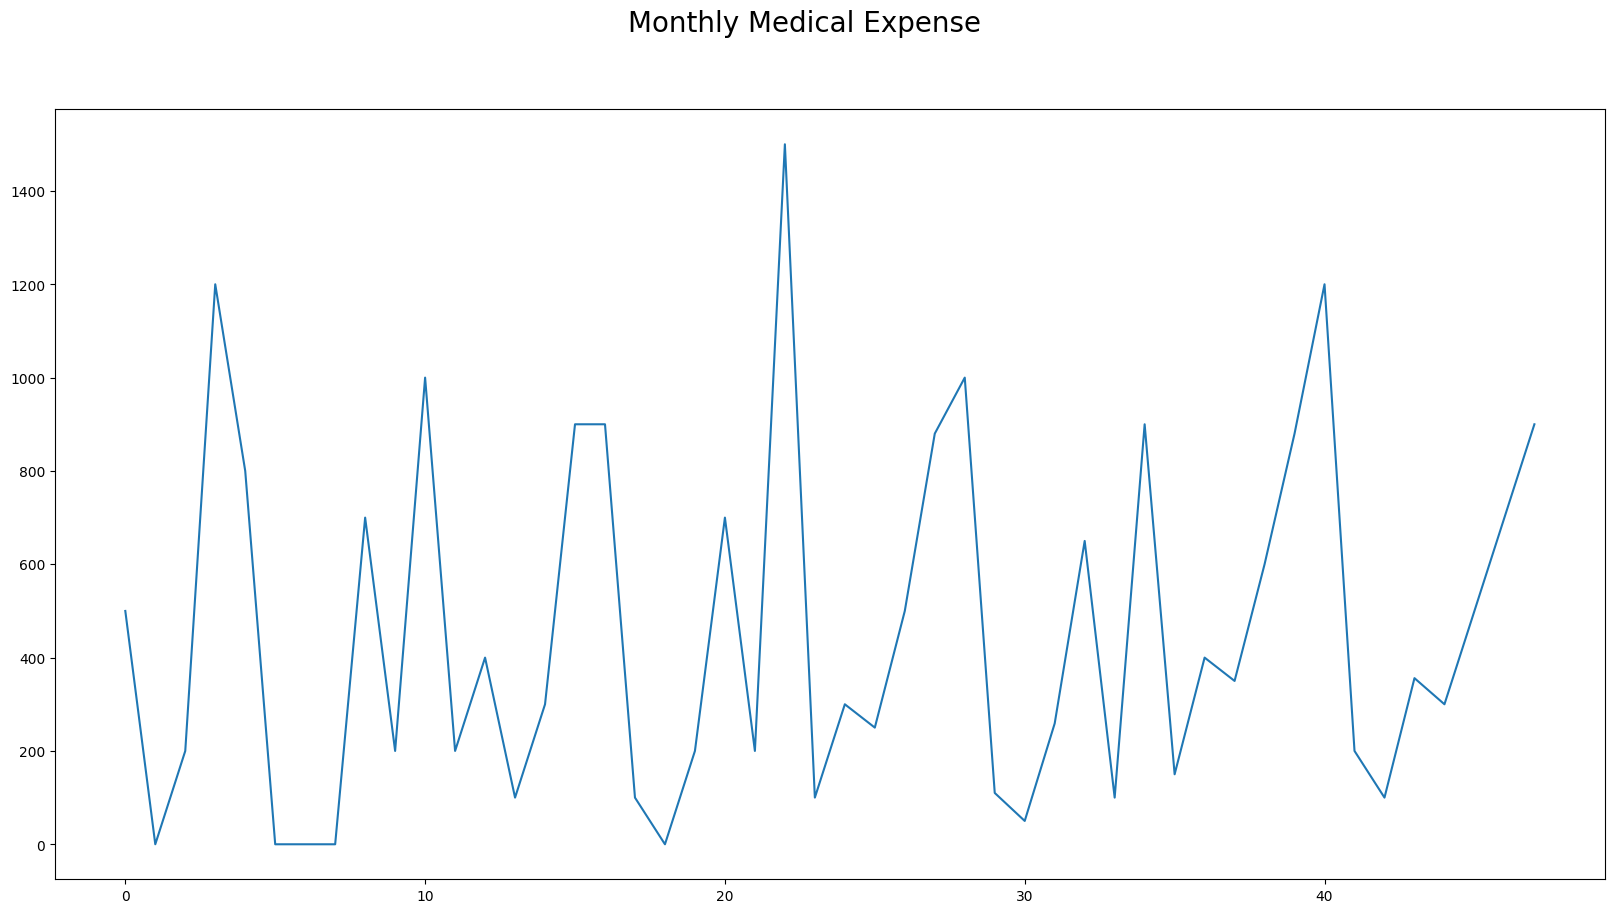

In [4]:
plt.figure(figsize=(20,10)).suptitle("Monthly Medical Expense", fontsize=20)
plt.plot(expense)
plt.show()

In [5]:
#Scale the data
print("Expense Range before scaling : ",min(expense.Amount),max(expense.Amount))

scaler = StandardScaler()
scaled_expense=scaler.fit_transform(expense)

print("Expense Range after scaling : ",min(scaled_expense),max(scaled_expense))


Expense Range before scaling :  0 1500
Expense Range after scaling :  [-1.19766755] [2.75159115]


In [6]:
#Training data(sequencial) - first 3 years
train_size = 36
lookback=12
train_amount = scaled_expense[0:train_size,:]

#Add additional year for lookback.
test_requests = scaled_expense[train_size-lookback:,:]

print("\n Shaped of Train, Test : ",train_amount.shape, test_requests.shape)


 Shaped of Train, Test :  (36, 1) (24, 1)


In [7]:
# RNN dataset

def create_rnn_dataset(data1,lookback=1):
  data_x,data_y = [],[]
  for i in range(len(data1) - lookback -1):
    a=data1[i:(i+lookback),0]
    data_x.append(a)
    data_y.append(data1[i+lookback,0])
  return np.array(data_x),np.array(data_y)

In [8]:
train_x,train_y = create_rnn_dataset(train_amount,lookback)
# Reshape for LSTM
train_x = np.reshape(train_x,(train_x.shape[0],1, train_x.shape[1]))
print("Shape of X,Y : ",train_x.shape,train_y.shape)

Shape of X,Y :  (23, 1, 12) (23,)


In [9]:
tf.random.set_seed(3)
ts_model=Sequential()
ts_model.add(LSTM(256, input_shape=(1,lookback)))
ts_model.add(Dense(1))
ts_model.compile(loss="mean_squared_error",optimizer="adam",metrics=["mse"])
ts_model.summary()
ts_model.fit(train_x, train_y,  epochs=5, batch_size=1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               275456    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 275,713
Trainable params: 275,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 4s 10ms/step - loss: 0.8730 - mse: 0.8730
Epoch 2/5
23/23 [==============================] - 0s 12ms/step - loss: 0.5586 - mse: 0.5586
Epoch 3/5
23/23 [==============================] - 0s 11ms/step - loss: 0.3741 - mse: 0.3741
Epoch 4/5
23/23 [==============================] - 0s 10ms/step - loss: 0.2699 - mse: 0.2699
Epoch 5/5
23/23 [==============================] - 0s 10ms/step - loss: 0.

In [10]:
test_x, test_y = create_rnn_dataset(test_requests,lookback)
test_x = np.reshape(test_x,(test_x.shape[0],1, test_x.shape[1]))

In [11]:
ts_model.evaluate(test_x, test_y, verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 0.3041 - mse: 0.3041


[0.30414626002311707, 0.30414626002311707]

In [12]:
predict_on_train= ts_model.predict(train_x)
predict_on_test = ts_model.predict(test_x)
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test) 

1/1 [==============================] - 0s 39ms/step


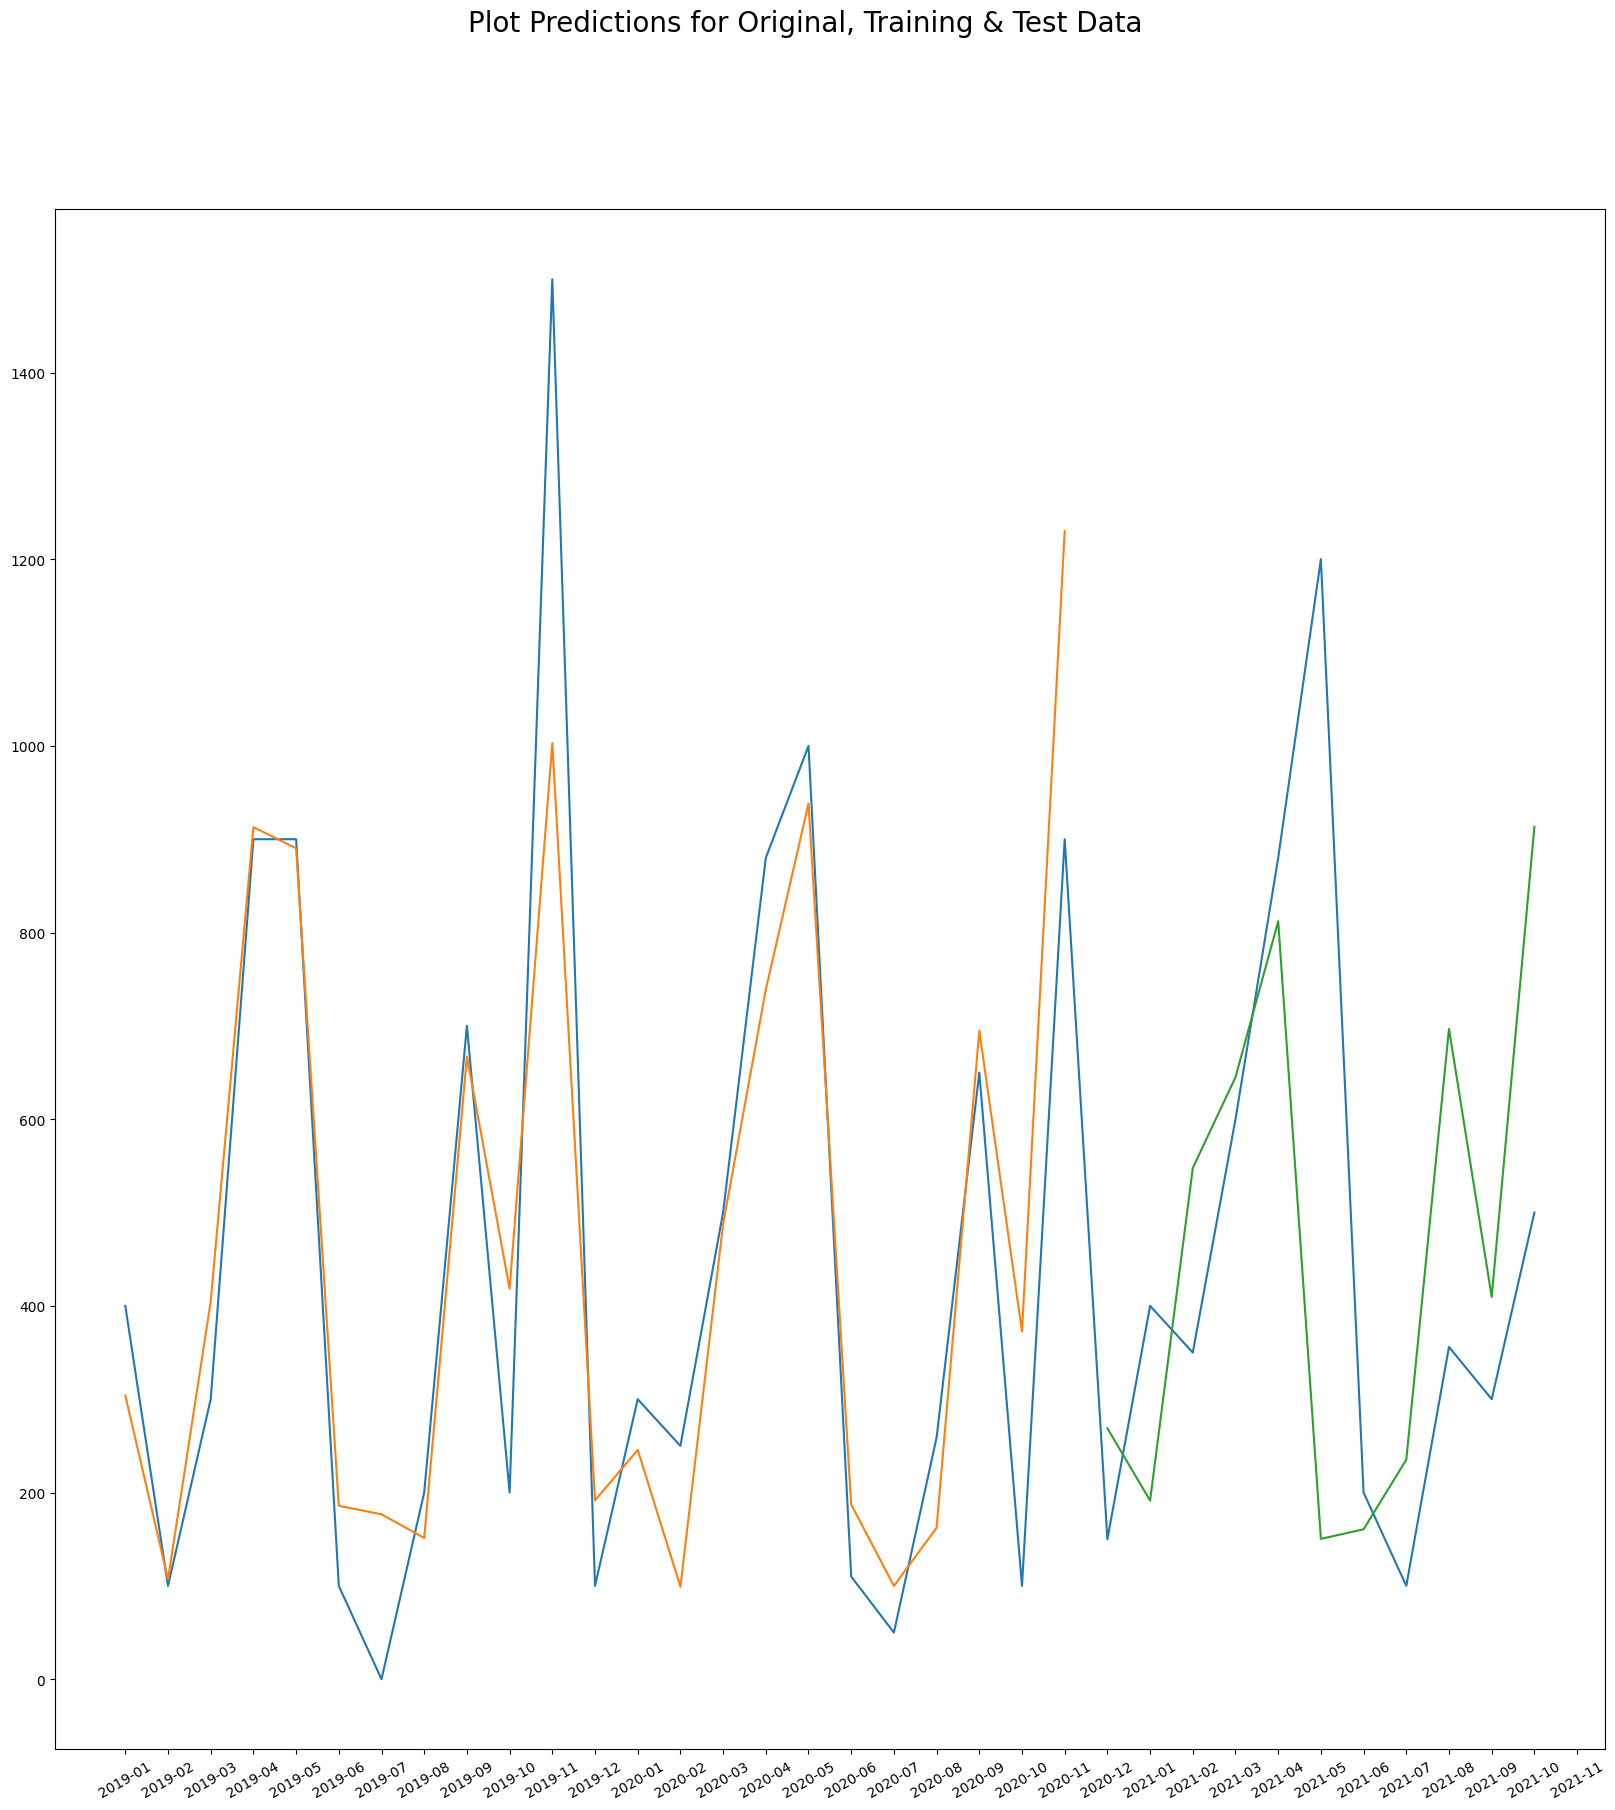

In [13]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train) + len(predict_on_test)

#Plot original data
orig_data=expense.Amount.to_numpy()
orig_data=orig_data.reshape(len(orig_data),1)

#Create a plot for original data
orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

#Create a plot for predictions on training
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Create a plot for predictions on testing
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :]= predict_on_test

#Plot the graphs
plt.figure(figsize=(20,20)).suptitle("Plot Predictions for Original, Training & Test Data", fontsize=20)
plt.xticks(np.arange(len(date)),date,rotation=30)
plt.plot(orig_plot)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()

## Future Expense Prediction

In [14]:
# Last training data point --> Initial lookback
curr_input= test_x[-1,:].flatten()

In [15]:
# Predict for next year
predict_for = 12

In [16]:
for i in range(predict_for):
  this_input = curr_input[-lookback:] # X = Last no.of.samples
  this_input = this_input.reshape((1,1,lookback))
  this_prediction = ts_model.predict(this_input) #Predict next data point
  curr_input = np.append(curr_input,this_prediction.flatten()) #Current prediction -> next input

1/1 [==============================] - 0s 39ms/step


In [17]:
# Last "predict_for" of curr_input contains all new predictions
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

In [18]:
# Inverse scale
predict_on_future=scaler.inverse_transform(predict_on_future)
# Results of 5 data points
print(predict_on_future[:5])

[[913.2394572 ]
 [250.31057194]
 [214.73773649]
 [217.47562003]
 [532.56517618]]


In [19]:
data['Date'] = pd.to_datetime(data['Date'])
plus_month_period = 1
dfd = data['Date'] + pd.DateOffset(months=predict_for)
d1 = dfd.dt.to_period('M')
d1.astype(str)

0     2020-01
1     2020-02
2     2020-03
3     2020-04
4     2020-05
5     2020-06
6     2020-07
7     2020-08
8     2020-09
9     2020-10
10    2020-11
11    2020-12
12    2021-01
13    2021-02
14    2021-03
15    2021-04
16    2021-05
17    2021-06
18    2021-07
19    2021-08
20    2021-09
21    2021-10
22    2021-11
23    2021-12
24    2022-01
25    2022-02
26    2022-03
27    2022-04
28    2022-05
29    2022-06
30    2022-07
31    2022-08
32    2022-09
33    2022-10
34    2022-11
35    2022-12
36    2023-01
37    2023-02
38    2023-03
39    2023-04
40    2023-05
41    2023-06
42    2023-07
43    2023-08
44    2023-09
45    2023-10
46    2023-11
47    2023-12
Name: Date, dtype: object

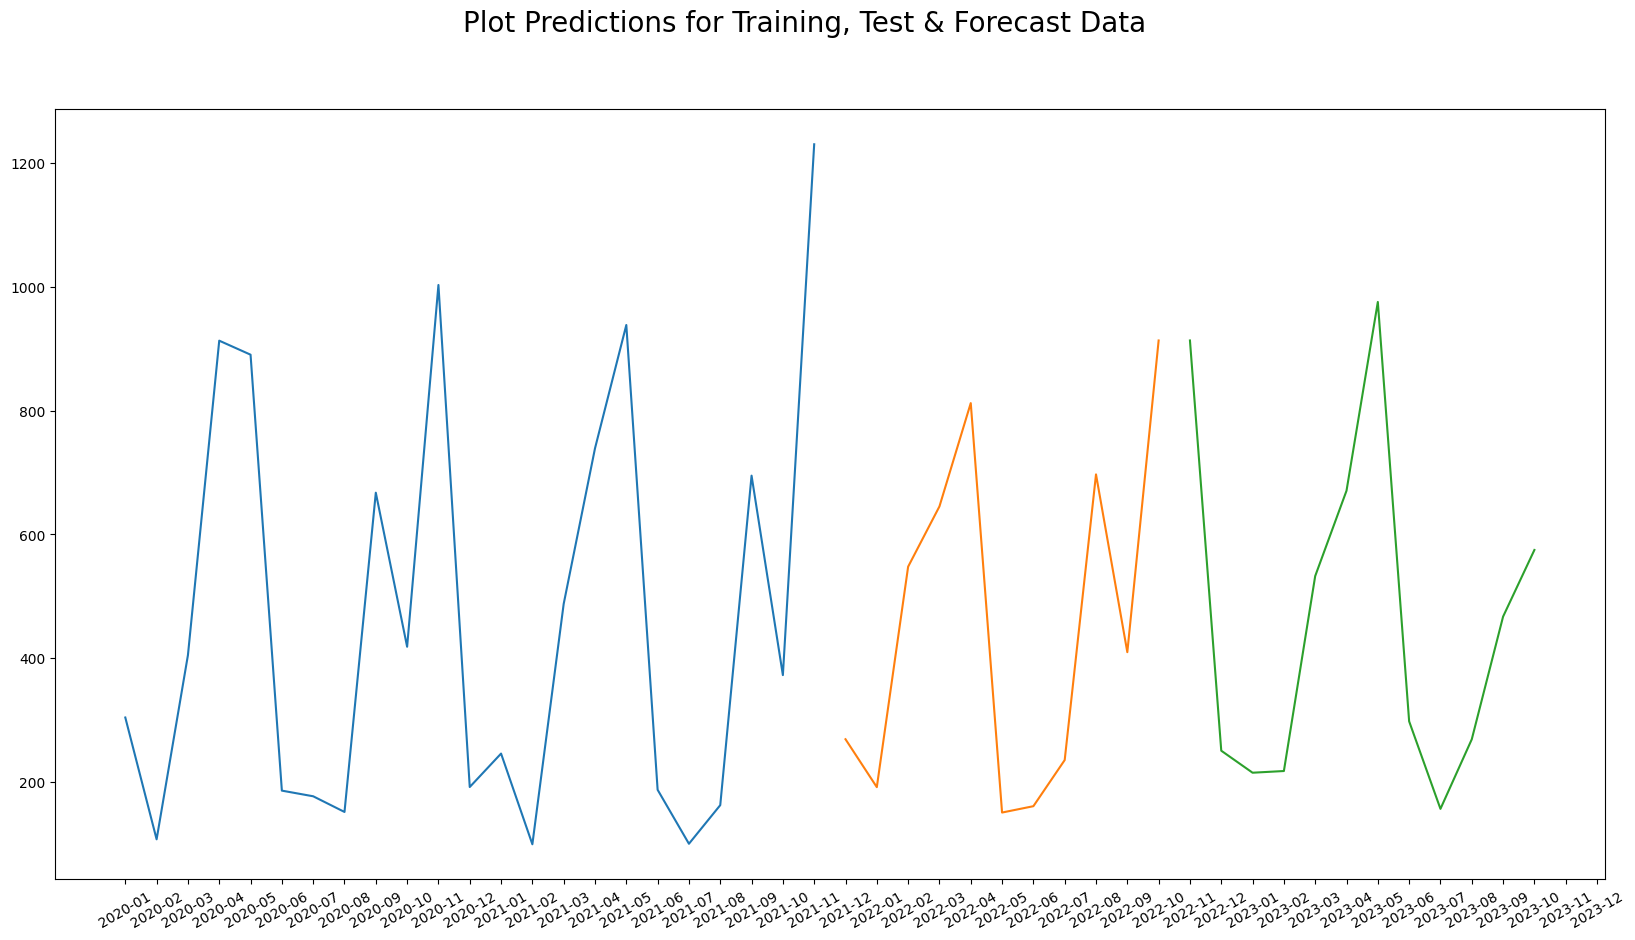

In [20]:
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

#Training data predictions
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Test data predictions
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test

# Future forecast dataset
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data", fontsize=20)
plt.xticks(np.arange(len(d1)),d1,rotation=30)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.plot(predict_future_plot)
plt.show()